![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/nlu/blob/master/examples/collab/Embeddings_for_Sentences/NLU_BERT_Sentence_Embeddings_and_t-SNE_visualizatio_Example.ipynb)

# BERT Sentence Embeddings with NLU 

BERT (Bidirectional Encoder Representations from Transformers) provides dense vector representations for natural language by using a deep, pre-trained neural network with the Transformer architecture.



## Sources :
- https://arxiv.org/abs/1810.04805
- https://github.com/google-research/bert

## Paper abstract

We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models, BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement).



# 1. Install Java and NLU

In [1]:

import os
! apt-get update -qq > /dev/null   
# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! pip install nlu > /dev/null    





## 2. Load Model and embed sample sentence with BERT Sentence Embedder

In [2]:
import nlu
pipe = nlu.load('embed_sentence.bert')
pipe.predict('He was suprised by the diversity of NLU')

sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


,sentence,embed_sentence_bert_embeddings
origin_index,,
0,He was suprised by the diversity of NLU,"[[-0.9174880981445312, 0.8030664920806885, -0...."


# 3. Download Sample dataset

In [3]:
import pandas as pd
# Download the dataset 
! wget -N https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv -P /tmp
# Load dataset to Pandas
df = pd.read_csv('/tmp/train-balanced-sarcasm.csv')
df

--2020-11-09 07:23:16--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.16.19
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.16.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255268960 (243M) [text/csv]
Saving to: ‘/tmp/train-balanced-sarcasm.csv’

train-balanced-sarc 100%[===================>] 243.44M  16.2MB/s    in 16s     

2020-11-09 07:23:33 (14.8 MB/s) - ‘/tmp/train-balanced-sarcasm.csv’ saved [255268960/255268960]



,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


# 4.1 Visualize Embeddings with T-SNE




Lets add Sentiment and Part Of Speech to our pipeline because its so easy and so we can hue our T-SNE plots by POS and Sentiment       

In [4]:
pipe = nlu.load('pos sentiment embed_sentence.bert') # emotion
df['text'] = df['comment']

# We must set output level to sentence since NLU will infer a different output level for this pipeline composition
predictions = pipe.predict(df[['text','label']].iloc[0:500], output_level='sentence')
predictions

pos_anc download started this may take some time.
Approximate size to download 4.3 MB
[OK!]
analyze_sentiment download started this may take some time.
Approx size to download 4.9 MB
[OK!]
sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


,text,embed_sentence_bert_embeddings,sentence,sentiment_confidence,label,document_assembler@sentiment,sentiment,checked,pos,sentence_detector@sentiment
origin_index,,,,,,,,,,
0,NC and NH.,"[-1.182037591934204, 1.0712522268295288, -1.57...",NC and NH.,0.522900,0,[NC and NH.],negative,"[NC, and, NH, .]","[NNP, CC, NNP, .]",NC and NH.
1,You do know west teams play against west teams...,"[-0.6950402855873108, 0.03453037515282631, -0....",You do know west teams play against west teams...,0.473300,0,[You do know west teams play against west team...,negative,"[You, do, know, west, teams, play, against, we...","[PRP, VBP, VB, NN, NNS, VBP, IN, NN, NNS, JJR,...",You do know west teams play against west teams...
2,"They were underdogs earlier today, but since G...","[-0.7290339469909668, 0.17603591084480286, -0....","They were underdogs earlier today, but since G...",0.511800,0,"[They were underdogs earlier today, but since ...",negative,"[They, were, underdogs, earlier, today, ,, but...","[PRP, VBD, NNS, RBR, NN, ,, CC, IN, NNP, NN, D...","They were underdogs earlier today, but since G..."
3,"This meme isn't funny none of the ""new york ni...","[-0.8008272051811218, 0.14805254340171814, 0.0...","This meme isn't funny none of the ""new york ni...",0.515500,0,"[This meme isn't funny none of the ""new york n...",negative,"[This, meme, isn't, funny, none, of, the, "", n...","[DT, NN, NN, JJ, NN, IN, DT, '', JJ, NNP, NN, ...","This meme isn't funny none of the ""new york ni..."
4,I could use one of those tools.,"[-1.4655261039733887, 0.6308497190475464, -0.9...",I could use one of those tools.,0.474500,0,[I could use one of those tools.],negative,"[I, could, use, one, of, those, tools, .]","[PRP, MD, VB, CD, IN, DT, NNS, .]",I could use one of those tools.
...,...,...,...,...,...,...,...,...,...,...
495,"CS 1.6, Source and GO Cities skylines Getting ...","[-0.39910757541656494, -0.39811980724334717, -...","CS 1.6, Source and GO Cities skylines Getting ...",0.452600,0,"[CS 1.6, Source and GO Cities skylines Getting...",positive,"[CS, 1.6, ,, Source, and, GO, Cities, skylines...","[NNP, CD, ,, NNP, CC, NNP, NNP, NNS, VBG, NN, ...","CS 1.6, Source and GO Cities skylines Getting ..."
496,"Or a ""Your Welcome""","[-1.8025215864181519, 0.9474198222160339, -0.8...","Or a ""Your Welcome""",0.592700,0,"[Or a ""Your Welcome""]",negative,"[Or, a, "", Your, Welcome, ""]","[CC, DT, '', PRP$, JJ, '']","Or a ""Your Welcome"""
497,But I want it to charge Super fast!,"[-1.1994625329971313, 0.28033140301704407, -1....",But I want it to charge Super fast!,0.430000,1,[But I want it to charge Super fast!],negative,"[But, I, want, it, to, charge, Super, fast, !]","[CC, PRP, VBP, PRP, TO, VB, NNP, RB, .]",But I want it to charge Super fast!


## 4.2 Checkout sentiment distribution

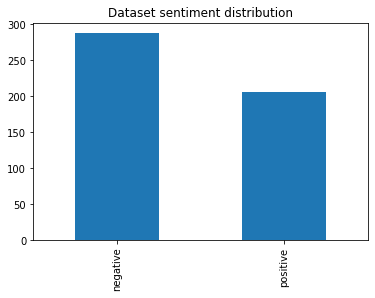

In [5]:
# Some Tokens are None which we must drop first
predictions.dropna(how='any', inplace=True)
# Some sentiment are 'na' which we must drop first
predictions = predictions[predictions.sentiment!= 'na']
predictions.sentiment.value_counts().plot.bar(title='Dataset sentiment distribution')

# 5.Prepare data for T-SNE algorithm.
We create a Matrix with one row per Embedding vector for T-SNE algorithm

In [6]:
import numpy as np

# Make a matrix from the vectors in the np_array column via list comprehension
mat = np.matrix([x for x in predictions.embed_sentence_bert_embeddings])

## 5.1 Fit and transform T-SNE algorithm


In [7]:

from sklearn.manifold import TSNE
model = TSNE(n_components=2) #n_components means the lower dimension
low_dim_data = model.fit_transform(mat)
print('Lower dim data has shape',low_dim_data.shape)

Lower dim data has shape (494, 2)


### Set plotting styles

In [8]:
# set some styles for for Plotting
import seaborn as sns
# Style Plots a bit
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1,rc={"lines.linewidth": 2.5})

%matplotlib inline
import matplotlib as plt
plt.rcParams['figure.figsize'] = (20, 14)
import matplotlib.pyplot as plt1



##5.2 Plot low dimensional T-SNE BERT Sentence embeddings with hue for Sarcasm


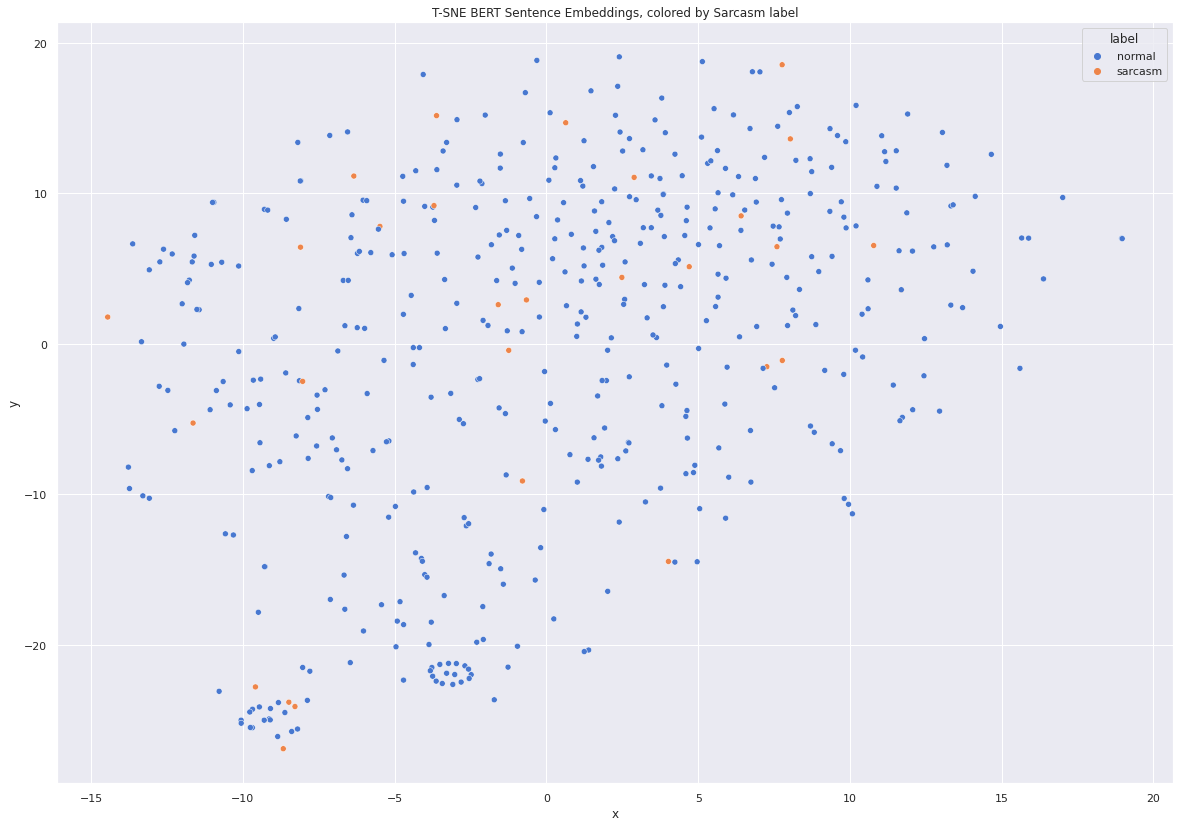

In [9]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.label.replace({1:'sarcasm',0:'normal'}))
tsne_df.columns = ['x','y']
ax = sns.scatterplot(data=tsne_df, x='x', y='y', hue=tsne_df.index)
ax.set_title('T-SNE BERT Sentence Embeddings, colored by Sarcasm label')
plt1.savefig("bert_sarcasam")


## 5.3 Plot low dimensional T-SNE BERT Sentence embeddings with hue for Sentiment


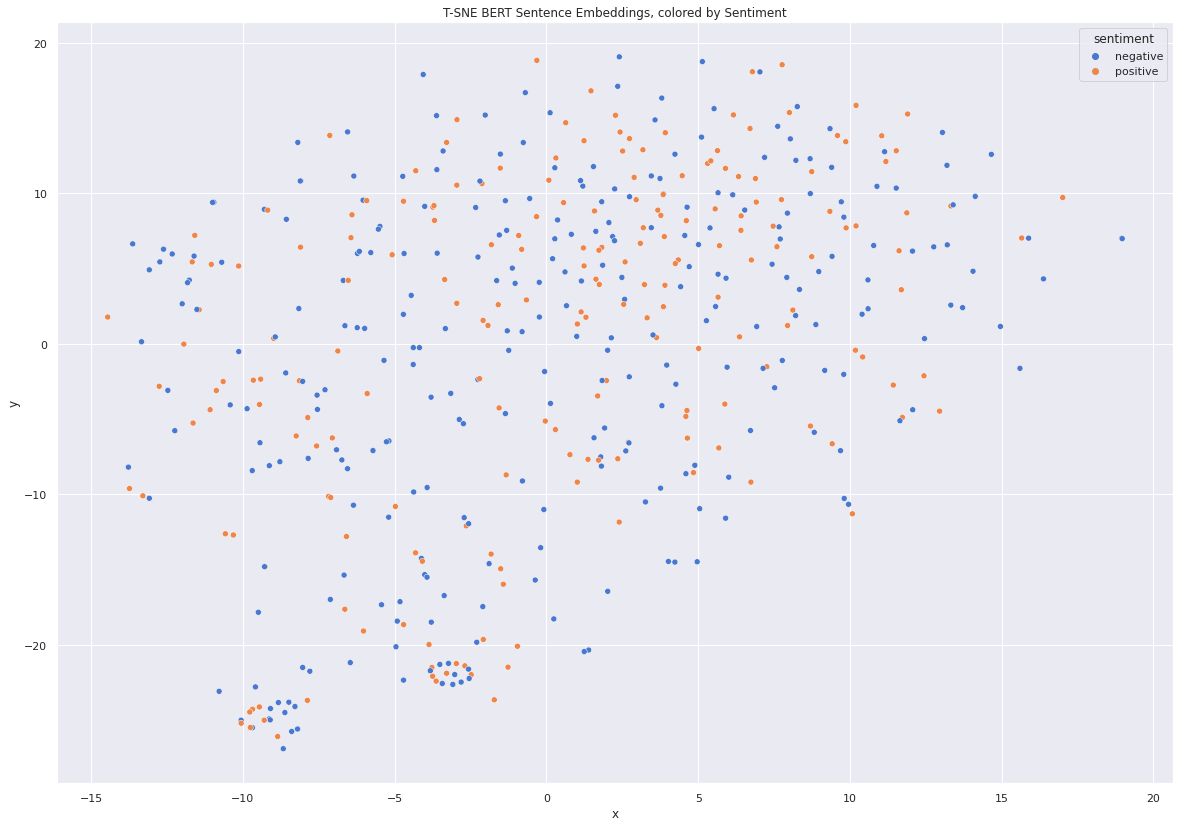

In [10]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.sentiment)
tsne_df.columns = ['x','y']
ax = sns.scatterplot(data=tsne_df, x='x', y='y', hue=tsne_df.index)
ax.set_title('T-SNE BERT Sentence Embeddings, colored by Sentiment')
plt1.savefig("bert_senitment")


# 6.1 Plot low dimensional T-SNE USE embeddings with hue for POS     
Because we will have a list of pos labels for each sentence, we need to explode on the pos column and then do the data peperation for T-SNE again before we can visualize with hue for POS


In [11]:
predictions_exploded_on_pos = predictions.explode('pos')
predictions_exploded_on_pos

,text,embed_sentence_bert_embeddings,sentence,sentiment_confidence,label,document_assembler@sentiment,sentiment,checked,pos,sentence_detector@sentiment
origin_index,,,,,,,,,,
0,NC and NH.,"[-1.182037591934204, 1.0712522268295288, -1.57...",NC and NH.,0.522900,0,[NC and NH.],negative,"[NC, and, NH, .]",NNP,NC and NH.
0,NC and NH.,"[-1.182037591934204, 1.0712522268295288, -1.57...",NC and NH.,0.522900,0,[NC and NH.],negative,"[NC, and, NH, .]",CC,NC and NH.
0,NC and NH.,"[-1.182037591934204, 1.0712522268295288, -1.57...",NC and NH.,0.522900,0,[NC and NH.],negative,"[NC, and, NH, .]",NNP,NC and NH.
0,NC and NH.,"[-1.182037591934204, 1.0712522268295288, -1.57...",NC and NH.,0.522900,0,[NC and NH.],negative,"[NC, and, NH, .]",.,NC and NH.
1,You do know west teams play against west teams...,"[-0.6950402855873108, 0.03453037515282631, -0....",You do know west teams play against west teams...,0.473300,0,[You do know west teams play against west team...,negative,"[You, do, know, west, teams, play, against, we...",PRP,You do know west teams play against west teams...
...,...,...,...,...,...,...,...,...,...,...
499,Hard drive requirements tend to include extra ...,"[-0.7308340668678284, 1.1065559387207031, -1.0...",Hard drive requirements tend to include extra ...,0.539600,0,[Hard drive requirements tend to include extra...,positive,"[Hard, drive, requirements, tend, to, include,...",IN,Hard drive requirements tend to include extra ...
499,Hard drive requirements tend to include extra ...,"[-0.7308340668678284, 1.1065559387207031, -1.0...",Hard drive requirements tend to include extra ...,0.539600,0,[Hard drive requirements tend to include extra...,positive,"[Hard, drive, requirements, tend, to, include,...",DT,Hard drive requirements tend to include extra ...
499,Hard drive requirements tend to include extra ...,"[-0.7308340668678284, 1.1065559387207031, -1.0...",Hard drive requirements tend to include extra ...,0.539600,0,[Hard drive requirements tend to include extra...,positive,"[Hard, drive, requirements, tend, to, include,...",NN,Hard drive requirements tend to include extra ...


## 6.2 Preprocess data for TSNE again

In [12]:

# Make a matrix from the vectors in the np_array column via list comprehension
mat = np.matrix([x for x in predictions_exploded_on_pos.embed_sentence_bert_embeddings])


from sklearn.manifold import TSNE
model = TSNE(n_components=2) #n_components means the lower dimension
low_dim_data = model.fit_transform(mat)
print('Lower dim data has shape',low_dim_data.shape)

Lower dim data has shape (6227, 2)


# 6.3 Plot low dimensional T-SNE BERT Sentence embeddings with hue for POS      


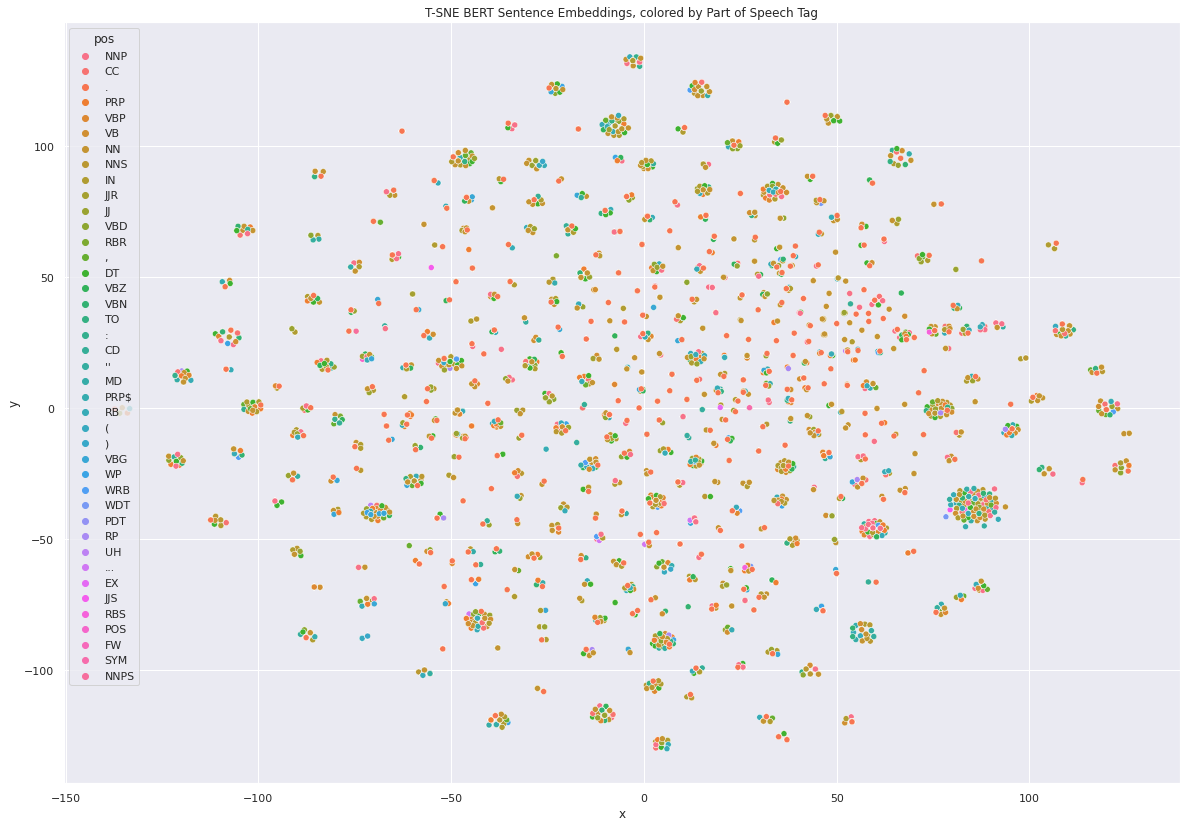

In [13]:
tsne_df =  pd.DataFrame(low_dim_data, predictions_exploded_on_pos.pos)
tsne_df.columns = ['x','y']
ax = sns.scatterplot(data=tsne_df, x='x', y='y', hue=tsne_df.index)
ax.set_title('T-SNE BERT Sentence Embeddings, colored by Part of Speech Tag')
plt1.savefig("bert_pos")


# 7. NLU has many more sentence embedding models!      
Make sure to try them all out!       
You can change 'embed_sentence.bert' in nlu.load('embed_sentence.bert') to bert, xlnet, albert or any other of the **20+ sentence embeddings** offerd by NLU

In [14]:
nlu.print_all_model_kinds_for_action('embed_sentence')

For language <en> NLU provides the following Models : 
nlu.load('en.embed_sentence') returns Spark NLP model tfhub_use
nlu.load('en.embed_sentence.use') returns Spark NLP model tfhub_use
nlu.load('en.embed_sentence.tfhub_use') returns Spark NLP model tfhub_use
nlu.load('en.embed_sentence.use.lg') returns Spark NLP model tfhub_use_lg
nlu.load('en.embed_sentence.tfhub_use.lg') returns Spark NLP model tfhub_use_lg
nlu.load('en.embed_sentence.albert') returns Spark NLP model albert_base_uncased
nlu.load('en.embed_sentence.electra') returns Spark NLP model sent_electra_small_uncased
nlu.load('en.embed_sentence.electra_small_uncased') returns Spark NLP model sent_electra_small_uncased
nlu.load('en.embed_sentence.electra_base_uncased') returns Spark NLP model sent_electra_base_uncased
nlu.load('en.embed_sentence.electra_large_uncased') returns Spark NLP model sent_electra_large_uncased
nlu.load('en.embed_sentence.bert') returns Spark NLP model sent_bert_base_uncased
nlu.load('en.embed_sentenc